In [4]:
import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter
import pickle
import scipy.io

from google.colab import drive
import sys
drive.mount("/content/drive", force_remount=True)

main_path = '/content/drive/My Drive/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x

Mounted at /content/drive


In [14]:
class ConfigAD:
   def __init__(self):
        # print("--------------------------------------------------call init--------------------------------------------------")
        self.T = 1
        self.T_unit = 1
        self.T_N = int(self.T / self.T_unit)
        self.T = 20.0 # collocation point?
        self.T_all = 20.0
        self.T_unit = 0.1
        self.N = int(self.T / self.T_unit)

        # self.NN = 160  # can be modified if too slow (20 / 50 / ...)
        # self.MM = 1  # must be 1 (fixed)
        self.Node = 640

        # parameters
        # Amyloid
        self.k_a = 2.1
        self.k_ta = 0.08
        self.k_mt = 0.718
        self.d_a = 0.06
        self.theta = 2
        # Tau
        self.k_t = 5
        self.k_at = 0.08
        self.k_ma = 0.7
        self.d_t = 0.06
        self.delta = 2
        # Neurodegeneration
        self.k_tn = 0.03566
        self.k_mtn = 0.08
        self.gamma = 3
        self.k_an = 0.05
        self.k_man = 5.022
        self.beta = 3
        self.k_atn = 0.03
        # Cognition
        self.k_r = 0.0846
        self.k_nc = 0.3596
        self.k_mn = 1.8944
        self.alpha = 2

        np.random.seed(0)

                  # self.u_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
                  # self.v_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])
                  # self.y_0 = np.concatenate([self.u_0, self.v_0])
        # self.y_0 = np.random.rand(self.NN, self.MM).reshape([self.NN * self.MM])

        self.ub = self.T
        self.lb = 0.0

        self.only_truth_flag = False  # True means only using loss_1 for truth_rate = 1.00, no other loss
        self.truth_rate = 1 #0.0034 # 0.0034 * 300 = 1 point(s) as truth #1.00 #0.25 #0.0005
        self.truth_length = int(self.truth_rate * self.T / self.T_unit)
        if not self.only_truth_flag:
            print("self.truth_length: {} of {} all ".format(self.truth_length, self.T_N))

        self.continue_period = 0.2
        self.round_bit = 3
        self.continue_id = None
        self.mapping_overall_flag = False
        self.loss2_partial_flag = False


In [6]:
def block_design_a(network_unit, sig):
    # print("--------------------------------------------------call block design a--------------------------------------------------")
    return nn.Sequential((OrderedDict({
      'lin1': nn.Linear(1, network_unit),
      'sig1': sig,
      'lin2': nn.Linear(network_unit, network_unit),
      'sig2': sig,
      'lin3': nn.Linear(network_unit, network_unit),
      'sig3': sig,
      'lin4': nn.Linear(network_unit, 1),
    })))

In [7]:
class SimpleNetworkAD(nn.Module):
  def __init__(self, config):
        # print("--------------------------------------------------call init of SimpleNetwork AD--------------------------------------------------")
        super(SimpleNetworkAD, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkAD"
        self.gt = GroundTruthAD(self.config.T, self.config.T_N)
        self.gt_data = torch.Tensor(self.gt.data).to(self.device)
        # self.gt_v = torch.Tensor(self.gt.v).to(self.device)

        self.sig = nn.Tanh()
        self.network_unit = 20

        # Design A
        A_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node)]
        T_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node)]
        N_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node)]
        C_blocks = [block_design_a(self.network_unit, self.sig) for i in range(self.config.Node)]

        self.sequences_A = nn.Sequential(*A_blocks)
        self.sequences_T = nn.Sequential(*T_blocks)
        self.sequences_N = nn.Sequential(*N_blocks)
        self.sequences_C = nn.Sequential(*C_blocks)


  def forward(self, inputs):
      # print("--------------------------------------------------call forward--------------------------------------------------")
      # print("call forward",inputs.shape)
      # A_input = inputs[:, :self.config.NN * self.config.MM]
      A_input = inputs[:, 0:160]
      A_output = [] 

      T_input = inputs[:, 160:320]
      T_output = []

      N_input = inputs[:, 320:480]
      N_output = []

      C_input = inputs[:, 480:640]
      C_output = []

      # print("A_input", A_input.shape)
      # print("T_input", T_input.shape)
      # print("N_input", N_input.shape)
      # print("C_input", C_input.shape)
      

      # Design A  
      for i in range(self.config.Node//4):
        # print(i,A_input[:,i:i+1].shape)
        A_output.append(self.sequences_A[i](A_input[:,i:i+1]))
        T_output.append(self.sequences_T[i](T_input[:,i:i+1]))
        N_output.append(self.sequences_N[i](N_input[:,i:i+1]))
        C_output.append(self.sequences_C[i](C_input[:,i:i+1]))

      A_output = torch.cat(tuple(item for item in A_output), 1)
      T_output = torch.cat(tuple(item for item in T_output), 1)
      N_output = torch.cat(tuple(item for item in N_output), 1)
      C_output = torch.cat(tuple(item for item in C_output), 1)
      
      # print("A_output", A_output.shape)
      # print("T_output", T_output.shape)
      # print("N_output", N_output.shape)
      # print("C_output", C_output.shape)

      outputs = torch.cat((A_output, T_output, N_output, C_output), 1)

      # print("outputs", outputs.shape)

      # print("forward outputs shape:",outputs.shape)
      return outputs
  
  def generate_x(self):
      # print("--------------------------------------------------call generate x--------------------------------------------------")
      # with open(main_path+'Data/scaled_first_scan_ATN.pkl', 'rb') as fin :
      #   x = pickle.load(fin)
      # self.x = torch.Tensor(x).float().to(self.device)
      x = [[i*self.config.T_unit for j in range(self.config.Node)] for i in range(self.config.N)]  # toy
      x = np.asarray(x)
      x = self.encode_t(x)
      print("continue_id = {}: [0, {}] is mapped to [{}, {}]".format(self.config.continue_id, self.config.T, len(x[0]), len(x[-1])))
      self.x = torch.Tensor(x).float().to(self.device)


  def initial_start(self):
      # print("--------------------------------------------------call initial start--------------------------------------------------")
      
      ######################################change t0
      # everything ending with 0 is for loss 1
      # WHY ALLL INPUT HAS TO BETWEEN -1/1
      # self.t0 = torch.Tensor(np.asarray(np.asarray([np.random.rand()] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)
      # print("self.t0",self.t0.shape)


      self.t0 = torch.Tensor(np.asarray(np.asarray([-1] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)

      # self.y0 = torch.Tensor(np.asarray([0.0, 0.0]).reshape([1, -1])).float().to(self.device)

      mat = scipy.io.loadmat(main_path+'Data/truth.mat')
      self.y0 = torch.Tensor(mat['pred'][-1,0,:]).reshape([1, -1]).float().to(self.device)
      # print("self.y0",self.y0.shape)


  def encode_t(self, num):
    # if not self.config.mapping_overall_flag:
    #     return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0
    return num / self.config.T_all * 2.0 - 1.0

  def decode_t(self, num):
      # if not self.config.mapping_overall_flag:
      #     return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)
      return (num + 1.0) / 2.0 * self.config.T_all

  def loss_only_ground_truth(self):
    # print("--------------------------------------------------call loss only ground truth--------------------------------------------------")
    self.eval()
    y = self.forward(self.x)
    self.loss_norm = torch.nn.MSELoss().to(self.device)
    # print(y.shape, self.gt_data.shape)
    loss = self.loss_norm(y, self.gt_data)
    self.train()
    return loss, [loss], []
  

  def loss(self):
    # print("--------------------------------------------------call loss--------------------------------------------------")
    self.eval()
    # print("--------------------------------------------------called eval--------------------------------------------------")
    # for loop *271
    y = self.forward(self.x)
    # print('y', y.shape)

    # print("y0_pred input, t0",self.t0.shape)
    y0_pred = self.forward(self.t0)
    # print('y0_pred', y0_pred.shape)
    # print("y.shape:", y[:, 0:1].shape)
    # print(y[:, 0:1])
    # print("self.x.shape:", self.x[:, 0:1].shape)
    # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
    # u = y[:, 0:1]
    # v = y[:, 1:2]

    A = y[:, 0:160]
    T = y[:, 160:320]
    N = y[:, 320:480]
    C = y[:, 480:640]

    # print("A", A.shape)
    # print("T", T.shape)
    # print("N", N.shape)
    # print("C", C.shape)

    A_t_collection, T_t_collection, N_t_collection, C_t_collection = [], [], [], []


    # print("--------------------------------------------------made to gradient--------------------------------------------------")
    # print("self.decode_t(self.x).shape: ",self.decode_t(self.x).shape)
    # print("self.decode_t(self.x)[:, 0:1].shape: ",self.decode_t(self.x)[:, 0:1].shape)
    # print("self.config.T_N", self.config.T_N)
    # print("spacing: ",(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),).shape)
    # u_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
    # v_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]  # y_t[:, 1:2]
    # u_t = u_t.reshape([self.config.N, 1])
    # v_t = v_t.reshape([self.config.N, 1])
    for ii in range(self.config.Node//4):
      # A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      # T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      # N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      # C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
      # print("A[:,ii:ii+1]", A[:,ii:ii+1].shape)
      # print("A[:,ii:ii+1].reshape([self.config.T_N])",A[:,ii:ii+1].reshape([self.config.N]).shape)
      # # print("torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]))",torch.gradient(A[:,ii:ii+1].reshape([self.config.N],-1)).shape)
      # print("torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]))[0]", torch.gradient(A[:,ii:ii+1].reshape([self.config.N]))[0].shape)

      ############################ add spacing
      A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]
      C_t_collection.append(torch.gradient(C[:,ii:ii+1].reshape([self.config.N]))[0].reshape([self.config.N,1]))  # u_t = y_t[:, 0:1]


    A_t = torch.cat(A_t_collection, 1)
    T_t = torch.cat(T_t_collection, 1)
    N_t = torch.cat(N_t_collection, 1)
    C_t = torch.cat(C_t_collection, 1) 
    

    # print("--------------------------------------------------gradient before reshape--------------------------------------------------")

    # print("A_t", A_t.shape)
    # print("T_t", T_t.shape)
    # print("N_t", N_t.shape)
    # print("C_t", C_t.shape)

    # print("--------------------------------------------------gradient after reshape--------------------------------------------------")

    # A_t = A_t.reshape([self.config.N, -1])
    # T_t = T_t.reshape([self.config.N, 1])
    # N_t = N_t.reshape([self.config.N, 1])
    # C_t = C_t.reshape([self.config.N, 1])

    # print("A_t", A_t.shape)
    # print("T_t", T_t.shape)
    # print("N_t", N_t.shape)
    # print("C_t", C_t.shape)



    mat = scipy.io.loadmat('/content/drive/My Drive/PINN/avgNetwork.mat')
    Laplacian = torch.Tensor(mat['avgNetwork']).float().to(self.device)
    r = 0.5

    # print("--------------------------------------------------finish gradient--------------------------------------------------")
    # print("A.shape, T.shape, Laplacian.shape",A.shape, T.shape, Laplacian.shape)
    # print(A*(1 - A))
    # print(self.config.k_a*A)
    # print("self.config.k_a*A*(1 - A).shape", self.config.k_a*A*(1 - A))
    # print(1)
    # print("self.config.k_ta / (np.power((self.config.k_mt/T),self.config.theta) + 1).shape",self.config.k_ta / (torch.pow((self.config.k_mt/T),self.config.theta) + 1))
    # print(2)
    # print("A.shape, Laplacian.shape",A.shape, Laplacian.shape)
    # print("self.config.d_a*np.dot(A,Laplacian).shape",self.config.d_a*torch.matmul(A,Laplacian))
    # print(3)

    ############### ut- gai
    ######################### dim: N*Node


#     dy(A) = k_a*y(A).*(1 - y(A)) + (k_ta* y(T).^theta)./ (k_mt^theta + y(T).^theta) - d_a*Laplacian*y(A);  % x_a
# % disp('A')
# dy(T) = k_t*y(T).*(1 - y(T)) + (k_at* y(A).^delta)./ (k_ma^delta + y(A).^delta) - d_t*Laplacian*y(T); 
# % disp('T')% x_t
# dy(N) = (k_tn*y(T).^gamma)./ (k_mtn^gamma + y(T).^gamma) + (k_an*y(A).^beta)./ (k_man^beta + y(A).^beta) + k_atn*y(A).*y(T);
# % disp('N')
# % dy(C) = mean(- k_r*r + k_nc ./ ((k_mn./y(N)).^alpha + 1));
# dy(C) = - k_r*r + (k_nc*y(N).^alpha) ./ (k_mn^alpha + y(N).^alpha);


    f_a = A_t - (self.config.k_a*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
    # print(f_a.shape)
    f_t = T_t - (self.config.k_t*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
    # print(f_t.shape)
    f_n = N_t - ((self.config.k_tn*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
                 (self.config.k_an*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
                 self.config.k_atn*A*T)
    # print(f_n.shape)
    f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
    # print(f_c.shape)
    # print(5)
    f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
    # print("--------------------------------------------------calculate gradient--------------------------------------------------")

    # L2 norm
    self.loss_norm = torch.nn.MSELoss().to(self.device)
    # print(1)
    zeros_1D = torch.Tensor([[0.0]] * self.config.N).to(self.device)
    # print(2)

    ##### match f_y. N*Node
    zeros_2D = torch.Tensor([[0.0 for i in range(self.config.Node )] for j in range( self.config.N )]).to(self.device)
    # print("###################################### zeros_2D", zeros_2D.shape)

    # loss_1 = self.loss_norm(y0_pred, self.y0)
    # print(3)
    loss_1 = self.loss_norm(y[:self.config.truth_length, :], self.gt_data[:self.config.truth_length, :])
    # print(4)



    # print("loss_1:", type(loss_1), loss_1.shape, loss_1)
    # self.loss_2_weight_numpy = generate_normal_distribution_weight_normal(self.config.N, 2, epoch_ratio)

    # self.loss_2_weight_numpy = generate_normal_distribution_weight(self.config.N, 2, (epoch % int(self.config.sliding_window_step)) / self.config.sliding_window_step)
    
    
    
    
    
    if self.config.loss2_partial_flag:
        new_period = int(self.config.continue_period * self.config.T_all / self.config.T_unit)
        loss_2 = self.loss_norm(f_y[-new_period:, :], zeros_2D[-new_period:, :])
    else:
        loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))
        # print(5)


        
    # loss_2_details_normed = torch.abs(f_y * torch.Tensor(self.loss_2_weight_numpy).to(self.device)).cpu().detach().numpy()
    # loss_2_details_original = torch.abs(f_y).cpu().detach().numpy()
    # print("loss_2_details shape:", loss_2_details.shape)
    # loss_3 = self.loss_norm((0.1/(u * u + v * v + 1e-12)), zeros_1D) + self.loss_norm(torch.abs(u), u) + self.loss_norm(torch.abs(v), v)

    # loss 4 penalty for negative


    loss = (loss_1 + loss_2) # + loss_3)#+ loss_4 + loss_5) / 1e5
    # if loss < 2.0:
    #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
    #     for i in range(20000):
    #         print(i, f_y_square_pure[i])
    self.train()
    return loss, [loss_1, loss_2], []
    # return torch.mean(torch.square(y_hat - y))
    # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
    # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)
  
  @staticmethod
  def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True
  

In [8]:
class GroundTruthAD:
  def __init__(self, t_max, length):
    # print("--------------------------------------------------call init ground truth AD--------------------------------------------------")
    # U_start = 10.0
    # V_start = 5.0
    # alpha = 1.0
    # beta = 3.0
    # gamma = 0.3
    # e = 0.333
    # self.t = np.linspace(0, t_max, length)
    # # print(t)
    # y0 = np.asarray([U_start, V_start])
    # self.data = odeint(self.pend, y0, self.t, args=(alpha, beta, gamma, e))

    with open(main_path+'Data/last_pt_YOUT.pkl', 'rb') as fin :
          x = pickle.load(fin)
    # self.data = torch.Tensor(x).float().to(self.device)
    # print("HERERERERE ", x.shape)
    self.data = torch.Tensor(x[1:,:]).float()
    # print("HERERERERE Data ", self.data.shape)

    # mat = scipy.io.loadmat(main_path+'Data/last_pt.mat')
    # self.data = torch.Tensor(mat['pred']).float()
  
  # 
  # def pend(y, t, a, b, c, d):
  #   map = y
  #   dydt = np.asarray([(a * map[0]) - c * map[0] * map[1], - b * map[1] + d * c * map[0] * map[1]])
  #   return dydt

  # def print(self):
  #   plt.figure(figsize=(8, 6))
  #   plt.plot(self.t, self.data[:, 0], 'b', label='u')
  #   plt.plot(self.t, self.data[:, 1], 'r', label='v')
  #   plt.show()
  #   plt.clf()
  #   plt.close()

def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))


In [9]:
def train_ad(model, args, config, now_string):
    # print("--------------------------------------------------call train AD--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    board_save_path = f"{args.main_path}/board/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_board"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    print("args = {}".format({item[0]: item[1] for item in args.__dict__.items() if item[0][0] != "_"}))
    print("config = {}".format({item[0]: item[1] for item in config.__dict__.items() if item[0][0] != "_"}))
    # gt = GroundTruthPP(config.T, config.N)
    writer = SummaryWriter(board_save_path)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1)) # decade
    # scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size=10000) # cyclic
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = 999999
    now_time = 0
    loss_record = []
    
    for epoch in range(1, args.epoch + 1):
        # print("in epoch ", epoch)
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        if config.only_truth_flag:
          # print("--------------------------------------------------loss only ground truth--------------------------------------------------")
          loss, loss_list, _ = model.loss_only_ground_truth()
        else:
          # print("--------------------------------------------------normal loss--------------------------------------------------")
          loss, loss_list, _ = model.loss()
        writer.add_scalar('Loss/train', loss.item(), epoch)
        
        # loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        # print("loss backward")
        # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        # _loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(closure)
        optimizer.step()
        scheduler.step()
        loss_record.append(float(loss.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (args.epoch - epoch)))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_ad(model, args, config, now_string, True, model.gt, None)
            # draw_loss(np.asarray(loss_record))
            # np.save(loss_save_path, np.asarray(loss_record))
    
    num_parameter = -1  # get_model_parameters(model, config)
    best_loss = best_loss
    time_cost = (now_time - start_time_0) / 60.0
    loss_record = np.asarray(loss_record)
    np.save(loss_save_path, loss_record)
    # draw_loss(loss_record)
    print("tensor board path: {}".format(board_save_path))
    print("%load_ext tensorboard")
    print("%tensorboard --logdir={}".format(board_save_path.replace(" ", "\ ")))
    # return [num_parameter, best_loss, time_cost, loss_record]
    return model

In [10]:
def test_sir_ages(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    s, i, r = y[:, 0:5], y[:, 5:10], y[:, 10:15]
    s = s.cpu().detach().numpy()
    i = i.cpu().detach().numpy()
    r = r.cpu().detach().numpy()
    x = model.decode_t(t).cpu().detach().numpy()

    plt.plot(x, y.cpu().detach().numpy()[:,0:160], 'b')
    plt.plot(x, y.cpu().detach().numpy()[:,160:320], 'g')
    plt.plot(x, y.cpu().detach().numpy()[:,321:480], 'y')
    plt.plot(x, y.cpu().detach().numpy()[:,481:640], 'c')
    plt.show()
    plt.close()
    # s_pred = [s[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    # i_pred = [i[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    # r_pred = [r[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    # x = x[:, 0:1].reshape([model.config.N])
    # for id in range(model.config.n):
    #   print(f"s{id+1}=", list(s_pred[id][:10]), "...", list(s_pred[id][-10:]))
    # for id in range(model.config.n):
    #   print(f"i{id+1}=", list(i_pred[id][:10]), "...", list(i_pred[id][-10:]))
    # for id in range(model.config.n):
    #   print(f"r{id+1}=", list(r_pred[id][:10]), "...", list(r_pred[id][-10:]))

    # figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    # labels = ["0-9", "10-19", "20-39", "40-59", "60+"]
    # color_list = ["red"] * model.config.n + ["blue"] * model.config.n + ["green"] * model.config.n
    # legend_list = ["S{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["I{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["R{}({})".format(i + 1, labels[i]) for i in range(model.config.n)]
    # line_style_list = ["dashed", "dotted", "dashdot", (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10))] * 3
    # draw_two_dimension(
    #     y_lists=s_pred+i_pred+r_pred,
    #     x_list=x,
    #     color_list=color_list,
    #     legend_list=legend_list,
    #     line_style_list=line_style_list,
    #     fig_title="Predict: SIR - Ages",
    #     fig_size=(32, 18),
    #     show_flag=True,
    #     save_flag=True,
    #     save_path=figure_save_path
    # )

In [ ]:
def test_ad(model, args, config, now_string, show_flag=True, gt=None, loss_2_details=None):
    # print("--------------------------------------------------call test ad--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    # model_save_path = f"{args.main_path}train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    # model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    # u, v = torch.chunk(y, 2, 1)
    # # print("u=", u)
    # # print("v=", v)
    # # u = model.decode_y(u)
    # # v = model.decode_y(v)
    # u = [item[0] for item in u.cpu().detach().numpy()]
    # v = [item[0] for item in v.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    # pairs = [[uu, vv, xx] for uu, vv, xx in zip(u, v, x)]
    # pairs.sort(key=lambda xx: xx[2])
    # u = [item[0] for item in pairs]
    # v = [item[1] for item in pairs]
    # x = [item[2] for item in pairs]
    # print("u=", u[:10], "...", u[-10:])
    # print("v=", v[:10], "...", v[-10:])
    # print("x=", x[:10], "...", x[-10:])
    # plt.plot(x, u, marker='.', markersize=0.2, linewidth=0.1, c="b")
    # plt.plot(x, v, marker='.', markersize=0.2, linewidth=0.1, c="r")
    plt.plot(x, y.cpu().detach().numpy()[:,0:160], 'b')
    plt.plot(x, y.cpu().detach().numpy()[:,160:320], 'g')
    plt.plot(x, y.cpu().detach().numpy()[:,321:480], 'y')
    plt.plot(x, y.cpu().detach().numpy()[:,481:640], 'c')
    plt.show()
    plt.close()
    
    # sw_weight = [item[0] for item in model.loss_2_weight_numpy]
    # figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}.png"
    # draw_two_dimension(
    #     y_lists=[u, v],
    #     x_list=x,
    #     color_list=["red", "blue"],
    #     legend_list=["u_pred", "v_pred"],
    #     line_style_list=["solid", "solid"],
    #     fig_title="PP - design D - Adam - noncyclic - norm2",
    #     fig_size=(8, 6),
    #     show_flag=True,
    #     save_flag=True,
    #     save_path=figure_save_path
    # )
    # x_model_memorized_truth = np.asarray(model.truth[0])
    # u_model_memorized_truth = np.asarray([item[0] for item in model.truth[1]])
    # v_model_memorized_truth = np.asarray([item[1] for item in model.truth[1]])



    # if gt:
    #     draw_two_dimension_different_x(
    #         y_lists=[gt.data[:config.N, 0:1], gt.data[:config.N, 1:2], u, v],
    #         x_lists=[x, x, x, x],
    #         color_list=["black", "black", "red", "blue"],
    #         legend_list=["u_truth", "v_truth", "u_pred", "v_pred"],
    #         line_style_list=["dashed", "dashed", "solid", "solid"],
    #         fig_title="PP - only truth - Adam - noncyclic - norm2",
    #         fig_size=(8, 6),
    #         show_flag=True,
    #         save_flag=True,
    #         save_path=figure_save_path
    #     )


    # plt.savefig(figure_save_path, dpi=300)
    # if show_flag:
    #     plt.show()
    # plt.clf()
    # print("Saved as {}".format(figure_save_path))

In [ ]:
# test_ad(model, args, self.config, now_string=get_now_string())

In [11]:
class Args:
    epoch = 5000
    epoch_step = 100
    lr = 0.01
    main_path = "."
    save_step = 200

class TestArgs:
    epoch = 1
    epoch_step = 1
    lr = 0.01
    main_path = "."
    save_step = 1


def run_ad_truth(model_1, main_path=None):
    # print("--------------------------------------------------call run ad truth--------------------------------------------------")
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    if not os.path.exists("{}/loss".format(args.main_path)):
        os.makedirs("{}/loss".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigAD()
    model = SimpleNetworkAD(config).to(device)
    model = train_ad(model, args, config, now_string)

    return model

def run_ad_truth_test(model_1, main_path=None):
    # print("--------------------------------------------------call run ad truth--------------------------------------------------")
    args = TestArgs
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    if not os.path.exists("{}/loss".format(args.main_path)):
        os.makedirs("{}/loss".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigAD()
    # model = SimpleNetworkAD(config).to(device)
    model = model_1
    model = train_ad(model, args, config, now_string)

    return model


In [15]:
################ 0.5 truth
mode1_1 = run_ad_truth(main_path)

self.truth_length: 200 of 1 all 
continue_id = None: [0, 20.0] is mapped to [640, 640]
using cpu
epoch = 5000
epoch_step = 100
model_name = SimpleNetworkAD
now_string = 2022-08-22-20-20-55
model_save_path_last = ./train/SimpleNetworkAD_5000_100_0.01_2022-08-22-20-20-55_last.pt
model_save_path_best = ./train/SimpleNetworkAD_5000_100_0.01_2022-08-22-20-20-55_best.pt
loss_save_path = ./loss/SimpleNetworkAD_5000_100_0.01_2022-08-22-20-20-55_loss_5000.npy
args = {'epoch': 5000, 'epoch_step': 100, 'lr': 0.01, 'main_path': '.', 'save_step': 200}
config = {'T': 20.0, 'T_unit': 0.1, 'T_N': 1, 'T_all': 20.0, 'N': 200, 'Node': 640, 'k_a': 2.1, 'k_ta': 0.08, 'k_mt': 0.718, 'd_a': 0.06, 'theta': 2, 'k_t': 5, 'k_at': 0.08, 'k_ma': 0.7, 'd_t': 0.06, 'delta': 2, 'k_tn': 0.03566, 'k_mtn': 0.08, 'gamma': 3, 'k_an': 0.05, 'k_man': 5.022, 'beta': 3, 'k_atn': 0.03, 'k_r': 0.0846, 'k_nc': 0.3596, 'k_mn': 1.8944, 'alpha': 2, 'ub': 20.0, 'lb': 0.0, 'only_truth_flag': False, 'truth_rate': 1, 'truth_length': 20

KeyboardInterrupt: ignored

self.truth_length: 200 of 1 all 
continue_id = None: [0, 20.0] is mapped to [640, 640]
using cpu
epoch = 1000
epoch_step = 100
model_name = SimpleNetworkAD
now_string = 2022-07-03-20-53-49
model_save_path_last = ./train/SimpleNetworkAD_1000_100_0.01_2022-07-03-20-53-49_last.pt
model_save_path_best = ./train/SimpleNetworkAD_1000_100_0.01_2022-07-03-20-53-49_best.pt
loss_save_path = ./loss/SimpleNetworkAD_1000_100_0.01_2022-07-03-20-53-49_loss_1000.npy
args = {'epoch': 1000, 'epoch_step': 100, 'lr': 0.01, 'main_path': '.', 'save_step': 100}
config = {'T': 20.0, 'T_unit': 0.1, 'T_N': 1, 'T_all': 20.0, 'N': 200, 'Node': 640, 'k_a': 0.5, 'k_ta': 0.5, 'k_mt': 0.5, 'd_a': 0.5, 'theta': 2, 'k_t': 0.5, 'k_at': 0.5, 'k_ma': 0.5, 'd_t': 0.5, 'delta': 2, 'k_tn': 0.5, 'k_mtn': 0.5, 'gamma': 2, 'k_an': 0.5, 'k_man': 0.5, 'beta': 2, 'k_atn': 0.5, 'k_r': 0.5, 'k_nc': 0.5, 'k_mn': 0.5, 'alpha': 2, 'ub': 20.0, 'lb': 0.0, 'only_truth_flag': False, 'truth_rate': 1, 'truth_length': 200, 'continue_period': 

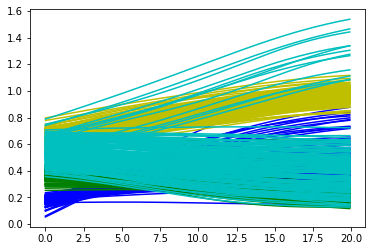

Epoch [00200/01000] Loss:0.323658 Loss_1:0.224139 Loss_2:0.099519 Lr:0.009804 Time:124.401183s (4.11min in total, 16.44min remains)
Testing & drawing...


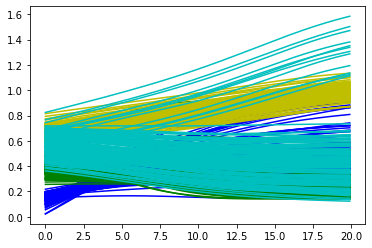

Epoch [00300/01000] Loss:0.323546 Loss_1:0.224051 Loss_2:0.099495 Lr:0.009709 Time:123.472244s (6.17min in total, 14.39min remains)
Testing & drawing...


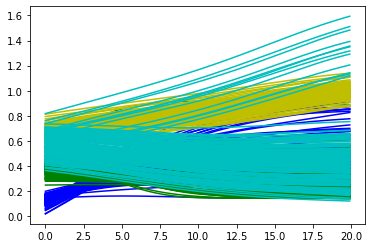

Epoch [00400/01000] Loss:0.323485 Loss_1:0.223946 Loss_2:0.099539 Lr:0.009615 Time:123.724260s (8.23min in total, 12.35min remains)
Testing & drawing...


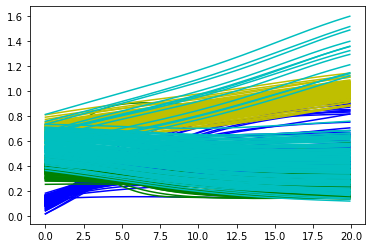

Epoch [00500/01000] Loss:0.323445 Loss_1:0.223887 Loss_2:0.099558 Lr:0.009524 Time:125.377280s (10.32min in total, 10.32min remains)
Testing & drawing...


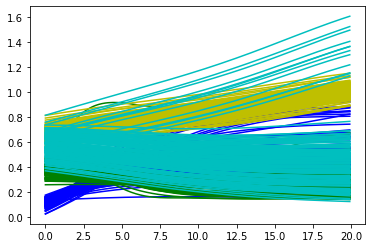

Epoch [00600/01000] Loss:0.323408 Loss_1:0.223803 Loss_2:0.099605 Lr:0.009434 Time:123.156997s (12.37min in total, 8.25min remains)
Testing & drawing...


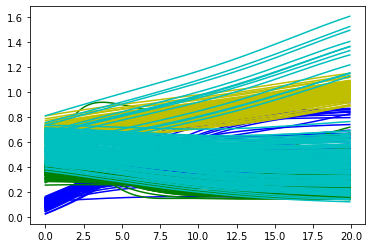

Epoch [00700/01000] Loss:0.323383 Loss_1:0.223810 Loss_2:0.099573 Lr:0.009346 Time:121.593556s (14.40min in total, 6.17min remains)
Testing & drawing...


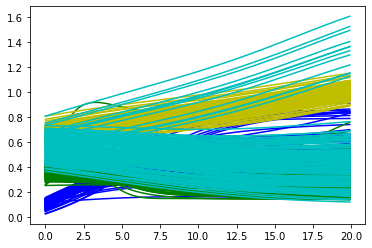

Epoch [00800/01000] Loss:0.323416 Loss_1:0.223640 Loss_2:0.099776 Lr:0.009259 Time:123.451245s (16.46min in total, 4.11min remains)
Testing & drawing...


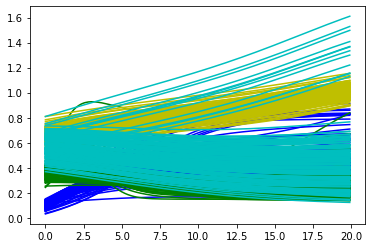

Epoch [00900/01000] Loss:0.323354 Loss_1:0.223507 Loss_2:0.099847 Lr:0.009174 Time:120.347423s (18.46min in total, 2.05min remains)
Testing & drawing...


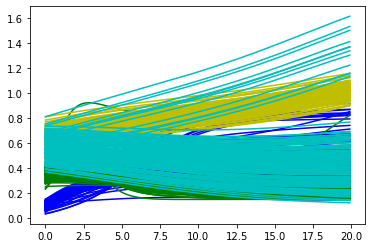

Epoch [01000/01000] Loss:0.323441 Loss_1:0.223420 Loss_2:0.100022 Lr:0.009091 Time:121.997141s (20.50min in total, 0.00min remains)
Testing & drawing...


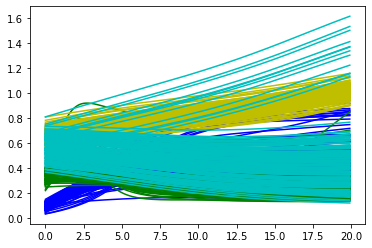

tensor board path: ./board/SimpleNetworkAD_1000_100_0.01_2022-07-03-20-53-49_board
%load_ext tensorboard
%tensorboard --logdir=./board/SimpleNetworkAD_1000_100_0.01_2022-07-03-20-53-49_board


In [ ]:
#1.0 truth
mode1_2 = run_ad_truth(main_path)

continue_id = None: [0, 20.0] is mapped to [640, 640]
using cpu
epoch = 300
epoch_step = 100
model_name = SimpleNetworkAD
now_string = 2022-07-03-22-16-02
model_save_path_last = ./train/SimpleNetworkAD_300_100_0.01_2022-07-03-22-16-02_last.pt
model_save_path_best = ./train/SimpleNetworkAD_300_100_0.01_2022-07-03-22-16-02_best.pt
loss_save_path = ./loss/SimpleNetworkAD_300_100_0.01_2022-07-03-22-16-02_loss_300.npy
args = {'epoch': 300, 'epoch_step': 100, 'lr': 0.01, 'main_path': '.', 'save_step': 100}
config = {'T': 20.0, 'T_unit': 0.1, 'T_N': 1, 'T_all': 20.0, 'N': 200, 'Node': 640, 'k_a': 0.5, 'k_ta': 0.5, 'k_mt': 0.5, 'd_a': 0.5, 'theta': 2, 'k_t': 0.5, 'k_at': 0.5, 'k_ma': 0.5, 'd_t': 0.5, 'delta': 2, 'k_tn': 0.5, 'k_mtn': 0.5, 'gamma': 2, 'k_an': 0.5, 'k_man': 0.5, 'beta': 2, 'k_atn': 0.5, 'k_r': 0.5, 'k_nc': 0.5, 'k_mn': 0.5, 'alpha': 2, 'ub': 20.0, 'lb': 0.0, 'only_truth_flag': True, 'truth_rate': 1, 'truth_length': 200, 'continue_period': 0.2, 'round_bit': 3, 'continue_id': None

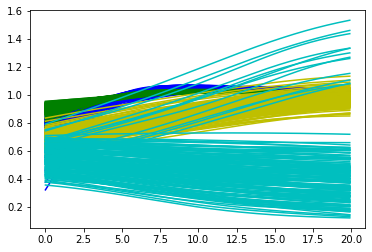

Epoch [00200/00300] Loss:0.000652 Loss_1:0.000652 Lr:0.009804 Time:91.078532s (2.96min in total, 1.48min remains)
Testing & drawing...


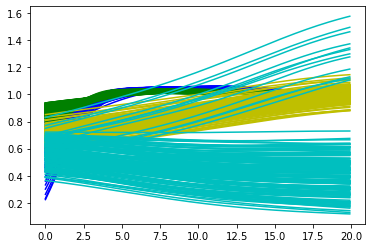

Epoch [00300/00300] Loss:0.000400 Loss_1:0.000400 Lr:0.009709 Time:95.438749s (4.55min in total, 0.00min remains)
Testing & drawing...


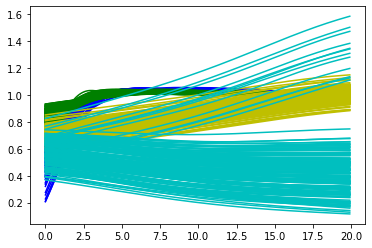

tensor board path: ./board/SimpleNetworkAD_300_100_0.01_2022-07-03-22-16-02_board
%load_ext tensorboard
%tensorboard --logdir=./board/SimpleNetworkAD_300_100_0.01_2022-07-03-22-16-02_board


In [ ]:
# truth = Ture
mode1_3 = run_ad_truth(main_path)

using cpu
epoch = 1
epoch_step = 1
model_name = SimpleNetworkAD
now_string = 2022-07-03-22-22-26
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_1_1_0.01_2022-07-03-22-22-26_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_1_1_0.01_2022-07-03-22-22-26_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_1_1_0.01_2022-07-03-22-22-26_loss_1.npy
args = {'epoch': 1, 'epoch_step': 1, 'lr': 0.01, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 1}
config = {'T': 20.0, 'T_unit': 0.1, 'T_N': 1, 'T_all': 20.0, 'N': 200, 'Node': 640, 'k_a': 0.5, 'k_ta': 0.5, 'k_mt': 0.5, 'd_a': 0.5, 'theta': 2, 'k_t': 0.5, 'k_at': 0.5, 'k_ma': 0.5, 'd_t': 0.5, 'delta': 2, 'k_tn': 0.5, 'k_mtn': 0.5, 'gamma': 2, 'k_an': 0.5, 'k_man': 0.5, 'beta': 2, 'k_atn': 0.5, 'k_r': 0.5, 'k_nc': 0.5, 'k_mn': 0.5, 'alpha': 2, 'ub': 20.0, 'lb': 0.0, 'only_truth_flag': True, 'truth_rate': 1, 'truth_length': 200, 'continue_period': 0.2, '

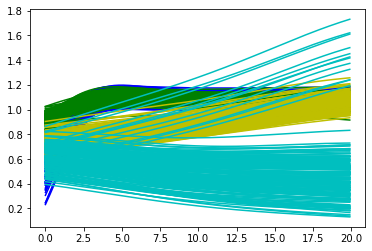

tensor board path: /content/drive/My Drive/PINN//board/SimpleNetworkAD_1_1_0.01_2022-07-03-22-22-26_board
%load_ext tensorboard
%tensorboard --logdir=/content/drive/My\ Drive/PINN//board/SimpleNetworkAD_1_1_0.01_2022-07-03-22-22-26_board


In [ ]:
tmp = run_ad_truth_test(mode1_3, main_path)

In [ ]:
zeros_2D = [[0.0 for i in range( 200)] for j in range(640)]
print("###################################### zeros_2D", len(zeros_2D[0]))


###################################### zeros_2D 200


In [ ]:
# def loss(self):
  #   print("--------------------------------------------------call loss--------------------------------------------------")
  #   self.eval()
  #   print("--------------------------------------------------called eval--------------------------------------------------")
  #   # for loop *271
  #   y = self.forward(self.x)
  #   print('y', y.shape)

  #   print("y0_pred input, t0",self.t0.shape)
  #   y0_pred = self.forward(self.t0)
  #   print('y0_pred', y0_pred.shape)
  #   # print("y.shape:", y[:, 0:1].shape)
  #   # print(y[:, 0:1])
  #   # print("self.x.shape:", self.x[:, 0:1].shape)
  #   # y_t = torch.gradient(y, spacing=(self.x,))[0]  # y_t = tf.gradients(y, t)[0]
  #   # u = y[:, 0:1]
  #   # v = y[:, 1:2]


  #   A = y[:, 0:1]
  #   T = y[:, 1:2]
  #   N = y[:, 2:3]
  #   C = y[:, 3:4]


    

  #   print("--------------------------------------------------made to gradient--------------------------------------------------")
  #   # u_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
  #   # v_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]  # y_t[:, 1:2]
  #   # u_t = u_t.reshape([self.config.N, 1])
  #   # v_t = v_t.reshape([self.config.N, 1])
  #   A_t = torch.gradient(A.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
  #   T_t = torch.gradient(T.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]  # y_t[:, 1:2]
  #   N_t = torch.gradient(N.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 2:3].reshape([self.config.N]),))[0]  # u_t = y_t[:, 0:1]
  #   C_t = torch.gradient(C.reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 3:4].reshape([self.config.N]),))[0]  # y_t[:, 1:2]

  #   print("--------------------------------------------------gradient before reshape--------------------------------------------------")

  #   print("A_t", A_t.shape)
  #   print("T_t", T_t.shape)
  #   print("N_t", N_t.shape)
  #   print("C_t", C_t.shape)


  #   print("--------------------------------------------------gradient after reshape--------------------------------------------------")

  #   A_t = A_t.reshape([self.config.N, 1])
  #   T_t = T_t.reshape([self.config.N, 1])
  #   N_t = N_t.reshape([self.config.N, 1])
  #   C_t = C_t.reshape([self.config.N, 1])

  #   print("A_t", A_t.shape)
  #   print("T_t", T_t.shape)
  #   print("N_t", N_t.shape)
  #   print("C_t", C_t.shape)


  #   print("--------------------------------------------------finish gradient--------------------------------------------------")
  #   # print(y_t,u_t)
  #   # f_u = u_t - (self.config.alpha - self.config.gamma * v) * u    # nn model
  #   # f_v = v_t - (-self.config.beta + self.config.e * self.config.gamma * u) * v    # nn model
  #   # f_u = u_t - torch.cos(self.decode_t(self.x)[:, 0:1])
  #   # f_v = v_t - torch.cos(self.decode_t(self.x)[:, 1:2])

  #   f_a = self.config.k_a*A*(1 - A) + self.config.k_ta / (np.power((self.config.k_mt/T),self.config.theta) + 1) - self.config.d_a*np.dot(A,Laplacian)
  #   f_t = self.config.k_t*T*(1 - T) + self.config.k_at / (np.power((self.config.k_ma/A),self.config.delta)  + 1) - self.config.d_t*np.dot(T,Laplacian)
  #   f_n = self.config.k_tn / (np.power((self.config.k_mtn/T),self.config.gamma) + 1) + self.config.k_an / (np.power((self.config.k_man/A),self.config.beta) + 1) + self.config.k_atn*A*T
  #   f_c = - self.config.k_r*r + self.config.k_nc / (np.power((self.config.k_mn/N),self.config.alpha) + 1);

  #   f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
  #   print("--------------------------------------------------calculate gradient--------------------------------------------------")
  #   # print((self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),).shape)
  #   # print(u_t.shape)

  #   # u_tt = torch.gradient(u_t, spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
  #   # v_tt = torch.gradient(v_t, spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
    
  #   # print_flag = False  # True # False
  #   # if print_flag:
  #   #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
  #   #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
  #   #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
  #   #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
  #   #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
  #   #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
  #   #     print("self.t0 =", self.t0, "self.encode_y(self.t0)=", self.encode_y(self.t0), "self.y0 =", self.y0,
  #   #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

  #   # loss_2_weights = [[i, i] for i in range(20000)]  # toy
  #   # loss_2_weights = np.asarray(loss_2_weights)
  #   # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

  #   # original
  #   # loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
  #   # loss_2 = torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))
  #   # loss_3 = torch.mean(torch.square((0.1/(u * u + v * v + 1e-12)))) + torch.mean(torch.square((torch.abs(u) - u))) + torch.mean(torch.square((torch.abs(v) - v)))

  #   # L2 norm
  #   self.loss_norm = torch.nn.MSELoss().to(self.device)
  #   zeros_1D = torch.Tensor([[0.0]] * self.config.N).to(self.device)
  #   zeros_2D = torch.Tensor([[0.0, 0.0]] * self.config.N).to(self.device)
  #   # loss_1 = self.loss_norm(y0_pred, self.y0)
  #   loss_1 = self.loss_norm(y[:self.config.truth_length, :], self.gt_data[:self.config.truth_length, :])



  #   # print("loss_1:", type(loss_1), loss_1.shape, loss_1)
  #   # self.loss_2_weight_numpy = generate_normal_distribution_weight_normal(self.config.N, 2, epoch_ratio)

  #   # self.loss_2_weight_numpy = generate_normal_distribution_weight(self.config.N, 2, (epoch % int(self.config.sliding_window_step)) / self.config.sliding_window_step)
  #   if self.config.loss2_partial_flag:
  #       new_period = int(self.config.continue_period * self.config.T_all / self.config.T_unit)
  #       loss_2 = self.loss_norm(f_y[-new_period:, :], zeros_2D[-new_period:, :])
  #   else:
  #       loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))
  #   # loss_2_details_normed = torch.abs(f_y * torch.Tensor(self.loss_2_weight_numpy).to(self.device)).cpu().detach().numpy()
  #   # loss_2_details_original = torch.abs(f_y).cpu().detach().numpy()
  #   # print("loss_2_details shape:", loss_2_details.shape)
  #   loss_3 = self.loss_norm((0.1/(u * u + v * v + 1e-12)), zeros_1D) + self.loss_norm(torch.abs(u), u) + self.loss_norm(torch.abs(v), v)
  #   # loss_4 = self.match_truth(self.accurate_x, y.cpu().detach().numpy())

  #   # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
  #   #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
  #   # loss_3 = torch.mean(torch.square((torch.abs(u) - u)))

  #   # loss_3 = torch.mean(torch.square((1/(u * u+ 1e-12)))) + torch.mean(torch.square((1/(v * v + 1e-12)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))

  #   # loss_3 = torch.mean(torch.square((1/(u * u + v * v)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))  # torch.mean(torch.square((1/(u * u + v * v + 1e-12)))) + torch.mean((torch.abs(u) - u)) + torch.mean((torch.abs(v) - v))
  #   # loss_4 = torch.mean(0.001 / (torch.abs(u_t)+1e-8)) + torch.mean(0.001 / (torch.abs(v_t)+1e-8))
  #   # loss_5 = torch.mean(0.001 / (torch.abs(u_tt)+1e-8)) + torch.mean(0.001 / (torch.abs(v_tt)+1e-8))
  #   loss = (loss_1 + loss_2) # + loss_3)#+ loss_4 + loss_5) / 1e5
  #   # if loss < 2.0:
  #   #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
  #   #     for i in range(20000):
  #   #         print(i, f_y_square_pure[i])
  #   self.train()
  #   return loss, [loss_1, loss_2, loss_3], []
  #   # return torch.mean(torch.square(y_hat - y))
  #   # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
  #   # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


In [ ]:

with open(main_path+'Data/last_pt_YOUT.pkl', 'rb') as fin :
      x = pickle.load(fin)

In [ ]:
x.shape

(201, 640)

SyntaxError: ignored

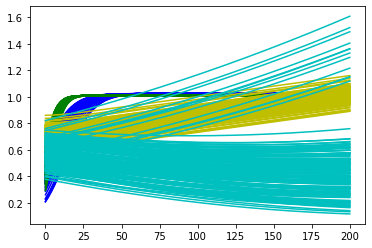

In [ ]:
plt.plot(x[:,0:160], 'b')
plt.plot(x[:,160:320], 'g')
plt.plot(x[:,321:480], 'y')
plt.plot(x[:,481:640], 'c')
plt.show()